In [0]:
import numpy as np
import pandas as pd
from scipy import stats
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import TransformerMixin
from scipy import stats
from sklearn import metrics
import lightgbm as lgb
from sklearn.model_selection import train_test_split

from google.colab import drive

drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path =  "/content/drive/My Drive/online_shoppers_intention.csv"

data = pd.read_csv(path)
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [0]:
def minmax_scaler(data, numerical_cols):
  """
  scaling the numerical data using minmax scaler
  args :
    data : dataframe
    numerical_cols : list of numerical columns
  return :
    minmax_df : dataframe with all numerical columns scaled
  """
  minmax_df = data.copy()
  scaler = MinMaxScaler()
  scaler.fit(data[numerical_cols])
  minmax_df[numerical_cols] = scaler.transform(data[numerical_cols])
  return minmax_df

def standard_scaler(data, numerical_cols):
  """
  scaling the numerical data using minmax scaler
  args :
    data : dataframe
    numerical_cols : list of numerical columns
  return :
    standard_df : dataframe with all numerical columns scaled
  """
  standard_df = data.copy()
  scaler = StandardScaler()
  scaler.fit(data[numerical_cols])
  standard_df[numerical_cols] = scaler.transform(data[numerical_cols])
  return standard_df


def zscore_outlier(data, numerical_cols):
  """
  To detect and remove outliers based on z-score
  args :
    data : dataframe
    numerical_cols : list of numerical columns
  return : 
    outlier_removed_z : dataframe whose outliers are removed
  """
  z = np.abs(stats.zscore(data[numerical_cols]))
  outlier_removed_z = data.copy()
  outlier_removed_z[numerical_cols] = data[numerical_cols][(z < 3).all(axis=1)]
  outlier_removed_z = outlier_removed_z.dropna()
  outlier_removed_z = outlier_removed_z.reset_index(drop=True)
  if (len(data.index)/ 2) > len(outlier_removed_z.index):
    return data
  return outlier_removed_z


def percentile_outlier(data, numerical_cols):
  """
  To detect and remove outliers based on percentile method
  args :
    data : dataframe
    numerical_cols : list of numerical columns
  return : 
    outlier_removed_percent : dataframe whose outliers are removed
  """
  Q1 = data[numerical_cols].quantile(0.25)
  Q3 = data[numerical_cols].quantile(0.75)
  IQR = Q3 - Q1
  outlier_removed_percent = data.copy()
  outlier_removed_percent[numerical_cols] = data[numerical_cols][~((data[numerical_cols] < (Q1 - 1.5 * IQR)) |(data[numerical_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
  outlier_removed_percent = outlier_removed_percent.dropna()
  outlier_removed_percent = outlier_removed_percent.reset_index(drop=True)
  if (len(data.index)/2) > len(outlier_removed_percent.index):
    return data
  return outlier_removed_percent


def busket_numerical_columns(data, numerical_cols):
  """
  To busket numerical columns for different buskets
  args :
    data : dataframe
    numerical_cols : list of numerical columns
  return :
    bin_df : dataframe whose name numerical columns are seperated into different columns
  """
  bin_df = data.copy()
  labels = [0,1,2,3,4,5,6,7,8,9]
  for column in data[numerical_cols]:
    if data[column].nunique() > 20 : 
      max_val = data[column].max() + data[column].max() + 0.000001
      min_val = data[column].min() + data[column].min() - 0.000001
      range_val = (max_val - min_val) / 9
      bins = [min_val - range_val]
      for i in range(1,10):
        bins.append((range_val * i + min_val))
      bins.append(max_val + range_val * 0.001)
      bin_df[f'binned_{column}'] = pd.cut(data[column], bins=bins, labels=labels)
      bin_df = bin_df.drop([column], axis =1)
  return bin_df


def encode_based_on_distribution(data):
  """
  encode to 1 and 0 based on the distribution if one value appears a lot in the column over the other values
  args :
    data : dataframe
  return :
    df : dataframe with the such columns where one appear more than the other got encoded
  """
  df = data.copy()
  for col in df.columns:
    x = df[col].value_counts().sort_values(ascending = False)
    y = df[col].value_counts().idxmax()
    if x[y] > (3 * len(df.index)/ 4) :
      df[f'max_{col}'] = [0 if x == y else 1 for x in df[col]]
  return df


def encode_dist_without_org(data):
  """
  encode to 1 and 0 based on the distribution if one value appears a lot in the column over the other values
  args :
    data : dataframe
  return :
    df : dataframe with the such columns where one appear more than the other got encoded and original columns removed
  """
  df = data.copy()
  for col in df.columns:
    x = df[col].value_counts().sort_values(ascending = False)
    y = df[col].value_counts().idxmax()
    if x[y] > (3 * len(df.index)/ 4) :
      df[f'max_{col}'] = [0 if x == y else 1 for x in df[col]]
      df.drop(col, axis = 1, inplace = True)
  return df



class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)



def get_col_missing_values(df):
    """
    get number of columns with missing values and 
    how many missing values each column has
    args :
        df : dataframe
    return :
        column names with missing values with number of missing values
    """
    # Number of missing values in each column of dataframe
    missing_val_count_by_column = (df.isnull().sum())
    return missing_val_count_by_column[missing_val_count_by_column > 0]


def imputer_column(df, strategy='mean'):
    """
    simple imputer to fill in missing values
    args :
        df : dataframe
        stratergy : stratergy used to fill in missing values
    return :
        dataframe where missing values are imputed
    """
    #getting the columns with missing values
    cols_with_missing = [col for col in df.columns
                     if df[col].isnull().any()]
    imputer = SimpleImputer(strategy = strategy)
    imputed_df = pd.DataFrame(imputer.fit_transform(df))

    # Imputation removed column names; put them back
    imputed_df.columns = df.columns
    return imputed_df


def drop_column(df):
    """
    drop columns with missing values
    args:
        df : dataframe
    return:
        dataframe without missing value columns
    """
    cols_with_missing = [col for col in df.columns
                     if df[col].isnull().any()]
    reduced_df = df.drop(cols_with_missing, axis = 1)
    return reduced_df


def impute_cat_num(df):
    """
    simple imputer to fill in missing values
    args :
        df : dataframe
    return :
        dataframe where missing values are imputed
    """
    imputed_df = DataFrameImputer().fit_transform(df)
    return imputed_df


def get_cat_features(df, support = 20):
    """
    to get all categorical features
    args:
        df : dataframe which is label encoded
        support : maximum amount of unique values column can have to consider it as categorical
    return:
        list of columns which are categorical
    """
    list_col = list(df)
    cat_col = []
    for i in list_col:
        if df[i].nunique() < support :
            cat_col.append(i)
    return cat_col


def oh_encoder(df):
    """
    function to one hot encode the values to a way that final column name have a meaning
    args : 
        dataframe
    return :
        dataframe that one hot encoded
    """
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)
    for col in object_cols:
        val = df[col].unique()
        for each in val :
            df[f'{each}_{col}'] = df[col].apply(lambda x : 1 if x == each else 0)
        df = df.drop([col], axis =1)
    return df


def label_encoder(df):
    """
    function to label encode the values to a way that final column name have a meaning
    args : 
        dataframe
    return :
        dataframe that label encoded
    """
    
    label_df = df.copy()
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)
    labelEncoder = LabelEncoder()
    for col in object_cols:
        label_df[col] = labelEncoder.fit_transform(df[col])

    return label_df

def oh_encoder(df, cat_cols):
    """
    function to one hot encode the values 
    args : 
        df : dataframe which is label encoded
        cat_cols : all categorical columns (from get_cat_features)
    return :
        dataframe that one hot encoded with all cat_cols
    """
    oh_df = df.copy()
    for col in cat_cols:
        val = oh_df[col].unique()
        for each in val :
            oh_df[f'{each}_{col}'] = oh_df[col].apply(lambda x : 1 if x == each else 0)
        oh_df = oh_df.drop([col], axis =1)
    return oh_df

def oh_label_encoder(df, support = 10):
    """
    function to one hot encode the values to a way that final column name have a meaning
    args : 
        df : dataframe which is label encoded (X)
        support : maximum amount of unique values column can have so that it should be one hot encoded
    return :
        dataframe that one hot encoded with all the coulumns with unique values less than the support
    """
    encoded_df = df.copy()
    cat_cols = get_cat_features(encoded_df, support)
    encoded_df = oh_encoder(encoded_df, cat_cols)
    return encoded_df


def drop_col_with_one_val(data):
  """
  drop columns with only one value as it does not affect any modelling
  args : 
    data : dataframe
  return :
    df : dataframe where columns with one values are drop
  """
  df = data.copy()
  for col in df.columns:
    if df[col].nunique() < 2 :
      df.drop(col, axis = 1 , inplace = True)
  return df


def date_parser(data):
  """
  to parse the date columns and split in to year, month, day, hour and minute
  args :
    data : dataframe
  return :
    df : dataframe with date columns splited into month, year, day, hour and minute
  """
  df = data.copy()
  for col in df.columns:
    if df[col].dtype == 'object':
        try:
          df[col] = pd.to_datetime(df[col])
        except ValueError:
          pass
  count = 0
  primary_date = ''
  for col in df.columns:
    if df[col].dtype == 'datetime64[ns]':
      count += 1
      df[col] = df[col].apply(lambda x : parse(str(x)))
      if count == 1:
        primary_date = col
      df[f'year_{col}'] = df[col].apply(lambda x : x.year)
      df[f'month_{col}'] = df[col].apply(lambda x : x.month)
      df[f'day_{col}'] = df[col].apply(lambda x : x.day)
      df[f'hour_{col}'] = df[col].apply(lambda x : x.hour)
      df[f'minute_{col}'] = df[col].apply(lambda x : x.minute)
      df.drop(col, axis = 1, inplace = True)

  return df

In [0]:
data = date_parser(data)
data.head()

AttributeError: ignored

In [0]:
data = impute_cat_num(data)
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [0]:
label_df = label_encoder(data)

In [0]:
from sklearn.metrics import mean_squared_error

def base_model(X_train, X_test, y_train, y_test):
  """
  base model for evaluating the dataframe
  
  """
  dtrain = lgb.Dataset(X_train, label=y_train)
  dvalid = lgb.Dataset(X_test, label=y_test)

  params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 64,
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

  print('Starting training...')
  # train
  gbm = lgb.train(params,
                  dtrain,
                  num_boost_round=12000,
                  valid_sets=dvalid,
                  early_stopping_rounds=2500)
  valid_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
  # eval
  valid_score = metrics.mean_squared_error(y_test, valid_pred) ** 0.5


  print(f"Validation AUC score: {valid_score:.4f}")
  return valid_score, gbm , valid_pred
  
def get_feature_cols(df, label):
  feature_cols = df.columns.drop(label)
  return feature_cols

def data_split(X, y):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)
  return X_train, X_test, y_train, y_test 

def get_X_y(df, label):
  feature_cols = get_feature_cols(df, label)
  return df[feature_cols], df[label]

def evaluate_df(X, y):
  X_train, X_test, y_train, y_test = data_split(X, y)
  score, model, valid_pred = base_model(X_train, X_test, y_train, y_test)
  return score, model, X_train, X_test, y_train, y_test, valid_pred


def get_numerical_cols(data):
  numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

  newdf = data.select_dtypes(include=numerics)

  numerical_cols = newdf.columns.values.tolist()
  return numerical_cols

In [0]:
X, y = get_X_y(label_df, 'Revenue')

score, model, X_train, X_test, y_train, y_test, valid_pred = evaluate_df(X, y)


In [0]:
y_test.head()
y_t = pd.DataFrame(y_test)
y_t.head()
valid_df = pd.DataFrame(valid_pred)

In [0]:
valid_df.head()

,0
0,0.116363
1,0.350504
2,0.612173
3,0.453293
4,0.220602


In [0]:
y_test[0] - valid_pred[0]

-0.11636263127307128

In [0]:
c = 0
n = 0
sum_error = 0
for i, row in y_t.iterrows():
  if y_test[i] != False:
    n += 1
    sum_error += (y_test[i] - valid_pred[c])/y_test[i]
  c += 1
accuracy = (1 - (sum_error / n)) * 100

In [0]:
print(accuracy)

52.33604600716972


In [0]:
feature_imp = pd.DataFrame({'Feature':X.columns, 'Value':model.feature_importance()})
feature_imp = feature_imp.set_index('Feature')
imp_dict = feature_imp.to_dict('dict')
feature_imp = imp_dict['Value']
feature_imp

{'Administrative': 97,
 'Administrative_Duration': 183,
 'BounceRates': 97,
 'Browser': 15,
 'ExitRates': 204,
 'Informational': 25,
 'Informational_Duration': 85,
 'Month': 128,
 'OperatingSystems': 25,
 'PageValues': 184,
 'ProductRelated': 179,
 'ProductRelated_Duration': 172,
 'Region': 66,
 'SpecialDay': 2,
 'TrafficType': 76,
 'VisitorType': 17,
 'Weekend': 20}

In [0]:
!pip install pdpbox

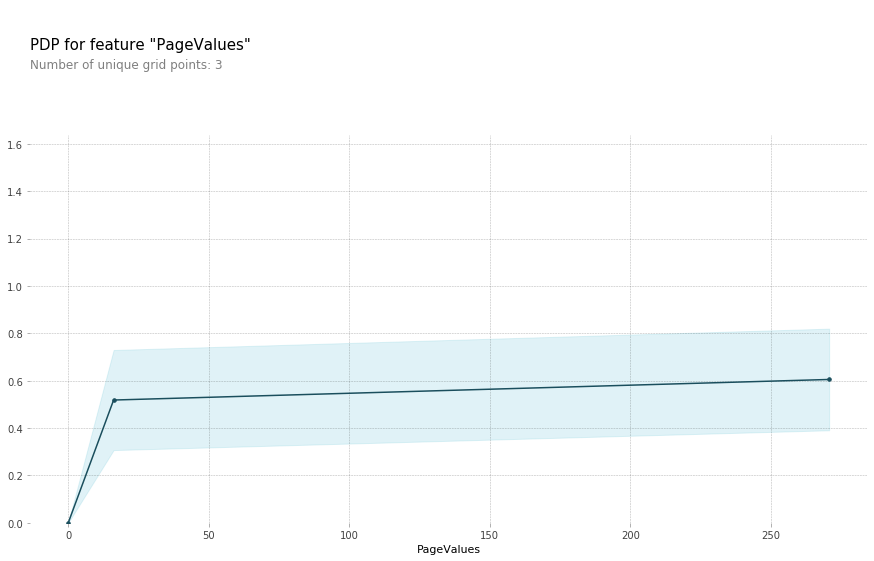

In [0]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

feature_names = [i for i in X_test.columns]

feature = 'PageValues'
# Create the data that we will plot
pdp_isolate = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature=feature)

# plot it
pdp.pdp_plot(pdp_isolate, feature)
plt.show()

In [0]:
y_pdp  = pdp_isolate.pdp

X_pdp = pdp_isolate.display_columns

X_pdp = [float(x) for x in X_pdp]

dict_pdp = {
    'column' : feature,
    'y' : y_pdp,
    'X' : X_pdp
}
dict_pdp

{'X': [0.0, 16.14, 270.78],
 'column': 'PageValues',
 'y': array([0.0517792 , 0.57017249, 0.65705094])}

In [0]:
dict_full_pdp = {}
for i in X_test.columns:
  feature = i
  # Create the data that we will plot
  pdp_isolate = pdp.pdp_isolate(model=model, dataset=X_test, model_features=feature_names, feature=feature)
  y_pdp  = pdp_isolate.pdp
  list_y = []
  for j in y_pdp:
    list_y.append(j)

  X_pdp = pdp_isolate.display_columns
  try :
    X_pdp = [float(x) for x in X_pdp]
  except ValueError:
    pass

  dict_pdp = {
      'column' : feature,
      'y' : list_y,
      'X' : X_pdp
  }
  print(i)
  dict_full_pdp[str(i)] = dict_pdp

Administrative
Administrative_Duration
Informational
Informational_Duration
ProductRelated
ProductRelated_Duration
BounceRates
ExitRates
PageValues
SpecialDay
Month
OperatingSystems
Browser
Region
TrafficType
VisitorType
Weekend


In [0]:
dict_full_pdp

{'Administrative': {'X': [0.0, 1.0, 2.0, 4.0, 7.0, 24.0],
  'column': 'Administrative',
  'y': [0.16416777602398738,
   0.16899896396889905,
   0.16412082514480214,
   0.15981926796718743,
   0.14614499909961456,
   0.12828362049806333]},
 'Administrative_Duration': {'X': [0.0, 21.2, 58.6, 106.3, 204.1, 3398.75],
  'column': 'Administrative_Duration',
  'y': [0.16339616468611032,
   0.15426997913081875,
   0.1558262202637831,
   0.1511349847215686,
   0.1511307927419613,
   0.15369057265380817]},
 'BounceRates': {'X': [0.0, 0.0, 0.01, 0.01, 0.02, 0.05, 0.2],
  'column': 'BounceRates',
  'y': [0.1645772137983368,
   0.15155265878858548,
   0.14025682817515997,
   0.13997330281871642,
   0.14348203286495512,
   0.13725208584885765,
   0.13725208584885765]},
 'Browser': {'X': [1.0, 2.0, 4.0, 13.0],
  'column': 'Browser',
  'y': [0.1531865652323555,
   0.15265607889647015,
   0.15296816197160876,
   0.15641932373356007]},
 'ExitRates': {'X': [0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.04, 0.05, 

In [0]:
X_test.iloc[0,:]

Administrative                      3
Administrative_Duration         142.5
Informational                       0
Informational_Duration              0
ProductRelated                     48
ProductRelated_Duration       1052.26
BounceRates                0.00434783
ExitRates                   0.0130435
PageValues                          0
SpecialDay                          0
Month                               7
OperatingSystems                    1
Browser                             8
Region                              6
TrafficType                        11
VisitorType                         2
Weekend                         False
Name: 8916, dtype: object

In [0]:
value = {'Administrative': 3,
 'Administrative_Duration': 142.5,
 'BounceRates': 0.00434783,
 'Browser': 8,
 'ExitRates': 0.0130435,
 'Informational': 0,
 'Informational_Duration': 0,
 'Month': 'July',
 'OperatingSystems': 1,
 'PageValues': 0,
 'ProductRelated': 48,
 'ProductRelated_Duration': 1052.26,
 'Region': 6,
 'SpecialDay': 0,
 'TrafficType': 11,
 'VisitorType': 2,
 'Weekend': False}

In [0]:
pred = {}
for i in value:
  pred[i] = [value[i]]

pred

{'Administrative': [3],
 'Administrative_Duration': [142.5],
 'BounceRates': [0.00434783],
 'Browser': [8],
 'ExitRates': [0.0130435],
 'Informational': [0],
 'Informational_Duration': [0],
 'Month': [nan],
 'OperatingSystems': [1],
 'PageValues': [0],
 'ProductRelated': [48],
 'ProductRelated_Duration': [1052.26],
 'Region': [6],
 'SpecialDay': [0],
 'TrafficType': [11],
 'VisitorType': [2],
 'Weekend': [False]}

In [0]:
df_pred = pd.DataFrame(pred)

In [0]:
df_pred.head()

,Administrative,Administrative_Duration,BounceRates,Browser,ExitRates,Informational,Informational_Duration,Month,OperatingSystems,PageValues,ProductRelated,ProductRelated_Duration,Region,SpecialDay,TrafficType,VisitorType,Weekend
0,3,142.5,0.004348,8,0.013043,0,0,NaN,1,0,48,1052.26,6,0,11,2,False


In [0]:
df_pred = date_parser(df_pred)
df_imp = data_imputer.transform(df_pred)
df_imp.head()

,Administrative,Administrative_Duration,BounceRates,Browser,ExitRates,Informational,Informational_Duration,Month,OperatingSystems,PageValues,ProductRelated,ProductRelated_Duration,Region,SpecialDay,TrafficType,VisitorType,Weekend
0,3,142.5,0.004348,8,0.013043,0,0,May,1,0,48,1052.26,6,0,11,2,False


In [0]:
label_df_pred = label_encoder(df_imp)

In [0]:
label_df_pred.head()

,Administrative,Administrative_Duration,BounceRates,Browser,ExitRates,Informational,Informational_Duration,Month,OperatingSystems,PageValues,ProductRelated,ProductRelated_Duration,Region,SpecialDay,TrafficType,VisitorType,Weekend
0,3,142.5,0.004348,8,0.013043,0,0,0,1,0,48,1052.26,6,0,11,2,False


In [0]:
y_pred = model.predict(label_df_pred)

In [0]:
label_df_pred.iloc[0,:]

Administrative                      3
Administrative_Duration         142.5
BounceRates                0.00434783
Browser                             8
ExitRates                   0.0130435
Informational                       0
Informational_Duration              0
Month                               0
OperatingSystems                    1
PageValues                          0
ProductRelated                     48
ProductRelated_Duration       1052.26
Region                              6
SpecialDay                          0
TrafficType                        11
VisitorType                         2
Weekend                         False
Name: 0, dtype: object

In [0]:
y_pred

array([0.82203365])

In [0]:
y_pred[0]

0.822033648477605

In [0]:
!pip install shap

In [0]:
import shap

shap.initjs()
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(label_df_pred)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0], label_df_pred.iloc[0,:])

In [0]:
shap_values[0]

array([ 3.81098403e-02,  4.38365732e-03, -9.59779592e-05,  5.04320235e-03,
        4.16417885e-02,  5.85483962e-02,  6.25523770e-02,  8.29675972e-02,
        3.21325159e-01, -4.52933210e-05,  1.82169026e-02, -9.64696322e-03,
       -1.57243353e-03,  3.91581240e-04,  5.11876833e-02, -4.97587558e-03,
       -3.37661009e-04])

In [0]:
X_pred = []
for i in label_df_pred.iloc[0,:]:
  X_pred.append(i)

df_X = pd.DataFrame(X_pred, index = label_df_pred.columns, columns =['X'])

X_dict = df_X.to_dict('dict')
X = X_dict['X']

shap_list = []
for i in shap_values[0] :
  shap_list.append(i)

df_shap = pd.DataFrame(shap_values[0], index = label_df_pred.columns, columns =['shap'])

shap_dict = df_shap.to_dict('dict')
sh = shap_dict['shap']
dict_shap = {}

for key in sh:
  dict_shap[key] = {}
  dict_shap[key]['shap'] = sh[key]
  dict_shap[key]['value'] = X[key]
dict_shap

{'Administrative': {'shap': 0.03810984027922596, 'value': 3},
 'Administrative_Duration': {'shap': 0.004383657317196467, 'value': 142.5},
 'BounceRates': {'shap': -9.597795915384503e-05, 'value': 0.00434783},
 'Browser': {'shap': 0.0050432023488469, 'value': 8},
 'ExitRates': {'shap': 0.041641788545560686, 'value': 0.0130435},
 'Informational': {'shap': 0.058548396218183904, 'value': 0},
 'Informational_Duration': {'shap': 0.06255237704180479, 'value': 0},
 'Month': {'shap': 0.08296759722252357, 'value': 0},
 'OperatingSystems': {'shap': 0.32132515858470073, 'value': 1},
 'PageValues': {'shap': -4.52933210136036e-05, 'value': 0},
 'ProductRelated': {'shap': 0.01821690261224123, 'value': 48},
 'ProductRelated_Duration': {'shap': -0.009646963215758177, 'value': 1052.26},
 'Region': {'shap': -0.0015724335258329976, 'value': 6},
 'SpecialDay': {'shap': 0.00039158124037536165, 'value': 0},
 'TrafficType': {'shap': 0.05118768325796412, 'value': 11},
 'VisitorType': {'shap': -0.00497587558028

In [0]:
path = '/content/drive/My Drive/drivendata/dengue_features_train.csv'

df = pd.read_csv(path)
df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [0]:
data, primary_date = date_parser(df)
data_imputer = DataFrameImputer()
data_imputer.fit(data)
data = data_imputer.transform(data)
data.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,year_week_start_date,month_week_start_date,day_week_start_date,hour_week_start_date,minute_week_start_date
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,1990,4,30,0,0
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,1990,5,7,0,0
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,1990,5,14,0,0
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,1990,5,21,0,0
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,1990,5,28,0,0


In [0]:
data.columns

Index(['city', 'year', 'weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'year_week_start_date',
       'month_week_start_date', 'day_week_start_date', 'hour_week_start_date',
       'minute_week_start_date'],
      dtype='object')

In [0]:
{
	Field: <<field>>,
	Aggregation: <<SUM or AVG or COUNT or UNIQUE_COUNT or MAX or MIN>>

	isSelected: <<TRUE or FALSE>>
}




val = {
    config : {
    Field_to_predict: ['station_diur_temp_rng_c'],
    summary: 'Month',
    measure: ['ndvi_ne', 'ndvi_nw', 'ndvi_se',
       'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm']
  }
}

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,year_week_start_date,month_week_start_date,day_week_start_date,hour_week_start_date,minute_week_start_date
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,1990,4,30,0,0
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,1990,5,7,0,0
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,1990,5,14,0,0
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,1990,5,21,0,0
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,1990,5,28,0,0


In [0]:
data.drop(['reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'], axis=1, inplace=True)

In [0]:
data.head()

,city,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,year_week_start_date,month_week_start_date,day_week_start_date,hour_week_start_date,minute_week_start_date
0,sj,1990,18,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,1990,4,30,0,0
1,sj,1990,19,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,1990,5,7,0,0
2,sj,1990,20,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,1990,5,14,0,0
3,sj,1990,21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,1990,5,21,0,0
4,sj,1990,22,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,1990,5,28,0,0


In [0]:
val = {
    "config" : {
      "Field_to_predict": ["reanalysis_air_temp_k"],

      "summary": {
        "Is_summarized": "TRUE",
        "Date": {
            "Field": "week_start_date",
            "Granualarity": "MONTH",
            "isSelected": "TRUE"
          }}
          ,
      "measure": [{"Field": "city", "Aggregation": "CAT"},{"Field": "year", "Aggregation": "DROP"},{"Field": "ndvi_ne", "Aggregation": "SUM"},{"Field": "ndvi_nw", "Aggregation": "AVG"},{"Field":"ndvi_se", "Aggregation": "MIN"},{"Field": "ndvi_sw", "Aggregation": "MAX"},{"Field": "precipitation_amt_mm", "Aggregation": "SUM"},{"Field": "reanalysis_air_temp_k", "Aggregation": "AVG"}]
  }
}

In [0]:
label = val["config"]['Field_to_predict']

summary = val["config"]['summary']

measure = val["config"]['measure']

In [0]:
summary_date_field = summary['Date']['Field']
grannualarity = summary["Date"]["Granualarity"]

In [0]:
val = {"returns" : np.sum}

In [0]:
dict_measure = {}
group_by = []
for i in measure:
  if i["Aggregation"] == "CAT":
    group_by.append(i["Field"])
  elif i["Aggregation"] == "MAX":
    dict_measure[i["Field"]] = np.max
  elif i["Aggregation"] == "MIN":
    dict_measure[i["Field"]] = np.min
  elif i["Aggregation"] == "SUM":
    dict_measure[i["Field"]] = np.sum
  elif i["Aggregation"] == "AVG":
    dict_measure[i["Field"]] = np.mean
    

In [0]:
dict_measure

{'ndvi_ne': <function numpy.sum>,
 'ndvi_nw': <function numpy.mean>,
 'ndvi_se': <function numpy.amin>,
 'ndvi_sw': <function numpy.amax>,
 'precipitation_amt_mm': <function numpy.sum>,
 'reanalysis_air_temp_k': <function numpy.mean>}

In [0]:
group_by

['city']

In [0]:
df1 = df.groupby(group_by).agg(dict_measure)

In [0]:
group_by.append(f'year_{summary_date_field}')
group_by.append(f'month_{summary_date_field}')


In [0]:
df1 = data.groupby(group_by).agg(dict_measure)

In [0]:
df1 = df1.reset_index()
df1.head()

,city,year_week_start_date,month_week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k
0,iq,2000,7,1.142848,0.209809,0.204114,0.361043,209.90,296.316000
1,iq,2000,8,1.310305,0.308785,0.231671,0.387271,196.91,297.594286
2,iq,2000,9,1.436786,0.264340,0.225714,0.328157,304.83,299.334286
3,iq,2000,10,1.203173,0.225866,0.277500,0.325800,151.78,298.900000
4,iq,2000,11,0.836383,0.172062,0.195486,0.279617,214.63,300.674643


In [0]:
val = {
    "config" : {
      "Field_to_predict": ["reanalysis_air_temp_k"],

      "summary": {
        "Is_summarized": "TRUE",
        "Date": {
            "Field": "week_start_date",
            "Granualarity": "MONTH",
            "isSelected": "TRUE"
          }}
          ,
      "measure": [{"Field": "city", "Aggregation": "CAT"},{"Field": "year", "Aggregation": "DROP"},{"Field": "ndvi_ne", "Aggregation": "SUM"},{"Field": "ndvi_nw", "Aggregation": "AVG"},{"Field":"ndvi_se", "Aggregation": "MIN"},{"Field": "ndvi_sw", "Aggregation": "MAX"},{"Field": "precipitation_amt_mm", "Aggregation": "SUM"},{"Field": "reanalysis_air_temp_k", "Aggregation": "AVG"}]
  }
}

In [0]:
def create_summary_df(data, val):

  df = data.copy()
  label = val["config"]['Field_to_predict']
  summary = val["config"]['summary']
  measure = val["config"]['measure']

  summary_date_field = summary['Date']['Field']
  grannualarity = summary["Date"]["Granualarity"]

  dict_measure = {}
  group_by = []
  for i in measure:
    if i["Aggregation"] == "CAT":
      group_by.append(i["Field"])
    elif i["Aggregation"] == "MAX":
      dict_measure[i["Field"]] = np.max
    elif i["Aggregation"] == "MIN":
      dict_measure[i["Field"]] = np.min
    elif i["Aggregation"] == "SUM":
      dict_measure[i["Field"]] = np.sum
    elif i["Aggregation"] == "AVG":
      dict_measure[i["Field"]] = np.mean

  
  if grannualarity == "MONTH" :
    group_by.append(f'year_{summary_date_field}')
    group_by.append(f'month_{summary_date_field}')
    df = df.groupby(group_by).agg(dict_measure)
  elif grannualarity == "YEAR" :
    group_by.append(f'year_{summary_date_field}')
    df = df.groupby(group_by).agg(dict_measure)
  df = df.reset_index()
  return df

In [0]:
df1 = create_summary_df(data, val)

In [0]:
df1.head()

,city,year_week_start_date,month_week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k
0,iq,2000,7,1.142848,0.209809,0.204114,0.361043,209.90,296.316000
1,iq,2000,8,1.310305,0.308785,0.231671,0.387271,196.91,297.594286
2,iq,2000,9,1.436786,0.264340,0.225714,0.328157,304.83,299.334286
3,iq,2000,10,1.203173,0.225866,0.277500,0.325800,151.78,298.900000
4,iq,2000,11,0.836383,0.172062,0.195486,0.279617,214.63,300.674643


In [0]:
path = path = '/content/drive/My Drive/sales_file.csv'

data = pd.read_csv(path)

data.head()

,Unnamed: 0,Transaction Date,Delivered Date,Last GRN Date,Month,Quarter,Financial Year,DoW,Weekday,Product,Location,Customer Grade,Quantity,Price,Discount,Sales
0,0,20140123,20140124,20131127,JAN,Q1,FY - 14,THU,Weekday,Beverage,New York,Regular,678.7,120,4072.2,77371800.0
1,1,20130304,20130316,20130113,MAR,Q1,FY - 13,MON,Weekday,Food,New York,Gold,15074.0,40,12059.2,590900800.0
2,2,20130219,20130226,20130126,FEB,Q1,FY - 13,TUE,Weekday,Vegetables,Tokyo,Platinum,7178.0,20,0.0,143560000.0
3,3,20161209,20161222,20160112,DEC,Q4,FY - 16,FRI,Weekday,Beverage,New York,Regular,4134.0,130,26871.0,510549000.0
4,4,20130528,20130611,20130320,MAY,Q2,FY - 13,TUE,Weekday,Beverage,New York,Regular,1812.0,100,9060.0,172140000.0


In [0]:
parse('20130403')

datetime.datetime(2013, 4, 3, 0, 0)

In [0]:
def date_parser(data):
  """
  to parse the date columns and split in to year, month, day, hour and minute
  args :
    data : dataframe
  return :
    df : dataframe with date columns splited into month, year, day, hour and minute
  """
  df = data.copy()
  column_datetype = []
  for col in df.columns:
    if df[col].dtype == 'object':
        try:
          df[col] = pd.to_datetime(df[col])
          column_datetype.append(col)
          df[col] = df[col].apply(lambda x : parse(str(x)))
          df[f'year_{col}'] = df[col].apply(lambda x : x.year)
          df[f'month_{col}'] = df[col].apply(lambda x : x.month)
          df[f'day_{col}'] = df[col].apply(lambda x : x.day)
          df.drop(col, axis = 1, inplace = True)
        except ValueError:
          pass       
    elif 'date' in col or 'Date' in col :
        try:
          column_datetype.append(col)
          df[col] = df[col].apply(lambda x : parse(str(x)))
          df[f'year_{col}'] = df[col].apply(lambda x : x.year)
          df[f'month_{col}'] = df[col].apply(lambda x : x.month)
          df[f'day_{col}'] = df[col].apply(lambda x : x.day)
          df.drop(col, axis = 1, inplace = True)
        except ValueError:
          pass

  return df, column_datetype

In [0]:
df, cols = date_parser(data)
print(cols)
df.head()

['Transaction Date', 'Delivered Date', 'Last GRN Date']


,Unnamed: 0,Month,Quarter,Financial Year,DoW,Weekday,Product,Location,Customer Grade,Quantity,Price,Discount,Sales,year_Transaction Date,month_Transaction Date,day_Transaction Date,year_Delivered Date,month_Delivered Date,day_Delivered Date,year_Last GRN Date,month_Last GRN Date,day_Last GRN Date
0,0,JAN,Q1,FY - 14,THU,Weekday,Beverage,New York,Regular,678.7,120,4072.2,77371800.0,2014,1,23,2014,1,24,2013,11,27
1,1,MAR,Q1,FY - 13,MON,Weekday,Food,New York,Gold,15074.0,40,12059.2,590900800.0,2013,3,4,2013,3,16,2013,1,13
2,2,FEB,Q1,FY - 13,TUE,Weekday,Vegetables,Tokyo,Platinum,7178.0,20,0.0,143560000.0,2013,2,19,2013,2,26,2013,1,26
3,3,DEC,Q4,FY - 16,FRI,Weekday,Beverage,New York,Regular,4134.0,130,26871.0,510549000.0,2016,12,9,2016,12,22,2016,1,12
4,4,MAY,Q2,FY - 13,TUE,Weekday,Beverage,New York,Regular,1812.0,100,9060.0,172140000.0,2013,5,28,2013,6,11,2013,3,20


In [0]:
label_df = label_encoder(df)
label_df.head()

,Unnamed: 0,Month,Quarter,Financial Year,DoW,Weekday,Product,Location,Customer Grade,Quantity,Price,Discount,Sales,year_Transaction Date,month_Transaction Date,day_Transaction Date,year_Delivered Date,month_Delivered Date,day_Delivered Date,year_Last GRN Date,month_Last GRN Date,day_Last GRN Date
0,0,4,0,1,3,0,0,2,2,678.7,120,4072.2,77371800.0,2014,1,23,2014,1,24,2013,11,27
1,1,7,0,0,1,0,1,2,0,15074.0,40,12059.2,590900800.0,2013,3,4,2013,3,16,2013,1,13
2,2,3,0,0,4,0,6,4,1,7178.0,20,0.0,143560000.0,2013,2,19,2013,2,26,2013,1,26
3,3,2,3,3,0,0,0,2,2,4134.0,130,26871.0,510549000.0,2016,12,9,2016,12,22,2016,1,12
4,4,8,1,0,4,0,0,2,2,1812.0,100,9060.0,172140000.0,2013,5,28,2013,6,11,2013,3,20


In [0]:
label_df.tail(20)

,Unnamed: 0,Month,Quarter,Financial Year,DoW,Weekday,Product,Location,Customer Grade,Quantity,Price,Discount,Sales,year_Transaction Date,month_Transaction Date,day_Transaction Date,year_Delivered Date,month_Delivered Date,day_Delivered Date,year_Last GRN Date,month_Last GRN Date,day_Last GRN Date
2955,2955,5,2,2,0,0,2,0,2,90.0,60,270.00,5.130000e+06,2015,7,10,2015,7,20,2015,8,7
2956,2956,2,3,2,4,0,1,3,0,34582.5,55,38040.75,1.863997e+09,2015,12,29,2016,1,7,2015,11,17
2957,2957,2,3,0,2,1,4,1,2,216.0,500,10800.00,9.720000e+07,2013,12,21,2013,12,26,2013,7,10
2958,2958,10,3,0,5,0,0,2,2,2688.0,100,13440.00,2.553600e+08,2013,10,23,2013,10,28,2013,2,10
2959,2959,4,0,0,4,0,0,2,2,939.0,100,4695.00,8.920500e+07,2013,1,29,2013,1,29,2013,8,1
2960,2960,1,2,2,4,0,1,2,0,872.5,55,959.75,4.702775e+07,2015,8,18,2015,8,18,2015,5,30
2961,2961,3,0,3,4,0,1,1,2,4188.6,60,12565.80,2.387502e+08,2016,2,9,2016,2,13,2016,8,1
2962,2962,10,3,1,0,0,2,0,0,105.6,55,116.16,5.691840e+06,2014,10,31,2014,11,13,2014,9,16
2963,2963,3,0,2,1,0,0,4,2,1225.0,170,10412.50,1.978375e+08,2015,2,2,2015,2,11,2014,6,12
2964,2964,10,3,0,2,1,6,2,2,37704.0,20,22622.40,7.314576e+08,2013,10,26,2013,10,30,2013,1,10


In [0]:
X, y = get_X_y(label_df, 'Sales')

score, model, X_train, X_test, y_train, y_test, valid_pred = evaluate_df(X, y)

Starting training...
[1]	valid_0's rmse: 1.34216e+09
Training until validation scores don't improve for 2500 rounds.
[2]	valid_0's rmse: 1.33666e+09
[3]	valid_0's rmse: 1.33119e+09
[4]	valid_0's rmse: 1.32602e+09
[5]	valid_0's rmse: 1.3208e+09
[6]	valid_0's rmse: 1.31603e+09
[7]	valid_0's rmse: 1.31086e+09
[8]	valid_0's rmse: 1.30567e+09
[9]	valid_0's rmse: 1.30052e+09
[10]	valid_0's rmse: 1.29539e+09
[11]	valid_0's rmse: 1.28995e+09
[12]	valid_0's rmse: 1.28466e+09
[13]	valid_0's rmse: 1.27928e+09
[14]	valid_0's rmse: 1.27444e+09
[15]	valid_0's rmse: 1.26911e+09
[16]	valid_0's rmse: 1.26382e+09
[17]	valid_0's rmse: 1.25858e+09
[18]	valid_0's rmse: 1.25338e+09
[19]	valid_0's rmse: 1.24807e+09
[20]	valid_0's rmse: 1.24307e+09
[21]	valid_0's rmse: 1.2382e+09
[22]	valid_0's rmse: 1.2331e+09
[23]	valid_0's rmse: 1.22828e+09
[24]	valid_0's rmse: 1.22323e+09
[25]	valid_0's rmse: 1.21821e+09
[26]	valid_0's rmse: 1.21279e+09
[27]	valid_0's rmse: 1.20741e+09
[28]	valid_0's rmse: 1.20264e+09
[29

In [0]:
X_test.head()

,Unnamed: 0,Month,Quarter,Financial Year,DoW,Weekday,Product,Location,Customer Grade,Quantity,Price,Discount,year_Transaction Date,month_Transaction Date,day_Transaction Date,year_Delivered Date,month_Delivered Date,day_Delivered Date,year_Last GRN Date,month_Last GRN Date,day_Last GRN Date
2403,2403,7,0,2,2,1,6,3,1,46540.0,40,0.00,2015,3,21,2015,3,31,2014,12,30
2865,2865,11,2,3,0,0,6,2,0,9040.2,55,4972.11,2016,9,16,2016,9,21,2016,8,13
2159,2159,1,2,2,3,0,0,3,0,187.5,170,637.50,2015,8,20,2015,8,29,2015,6,18
507,507,3,0,0,1,0,1,2,2,9216.0,40,18432.00,2013,2,25,2013,3,9,2013,3,1
2462,2462,5,2,0,1,0,1,0,2,2142.0,40,4284.00,2013,7,29,2013,8,1,2013,4,6


In [0]:
valid_pred.mean()

717307094.9060272

In [0]:
y_test.head()
y_t = pd.DataFrame(y_test)
y_t.head()
valid_df = pd.DataFrame(valid_pred)
y_t.head(10)

,Sales
2403,1.861600e+09
2865,4.922389e+08
2159,3.123750e+07
507,3.502080e+08
2462,8.139600e+07
1235,1.690000e+07
685,1.818459e+09
2436,6.840000e+07
2787,2.462849e+08
2645,6.086802e+08


In [0]:
valid_df.head(20)

,0
0,1.850545e+09
1,4.556905e+08
2,2.871480e+07
3,3.732132e+08
4,8.964567e+07
5,5.278373e+07
6,1.870901e+09
7,4.725958e+07
8,2.412326e+08
9,6.658758e+08


In [0]:
label_df_pred = X_test.copy()

In [0]:
!pip install shap

     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376825 sha256=54f753c92ccc5ad6c0b51e05f078829f78dab4fbe619fbea70f2fa6b4f5005a7
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
import shap

shap.initjs()
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(label_df_pred)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0], label_df_pred.iloc[0,:])

In [0]:
c = 0
n = 0
x = 0 
sum_error = 0
for i, row in y_t.iterrows():
  if y_test[i] != 0:
    if np.abs((y_test[i] - valid_pred[c])/y_test[i]) < 1 :
      sum_error += np.abs((y_test[i] - valid_pred[c])/y_test[i])
      n += 1
    else:
      x += 1
  c += 1
accuracy = (1 - (sum_error / n)) * 100

print(x)

124


In [0]:
accuracy

86.62362633070927

In [0]:

config = {
  "field_to_predict": "Sales",
      "summary": {
        "is_summarized": "TRUE",
          "date" : {
              "field": "Transaction Date",
              "granualarity": "MONTH",
              "isSelected": "FALSE" 
          }
      },
  "features": [
    {
      "field": "Transaction Date",
      "aggregation": "CATEGORICAL",
      "isSelected": "TRUE"
    },
    {
      "field": "Last GRN Date",
      "aggregation": "CATEGORICAL",
      "isSelected": "TRUE"
    },
    {
      "field": "Month",
      "aggregation": "CATEGORICAL",
      "isSelected": "TRUE"
    },
    {
      "field": "Quarter",
      "aggregation": "CATEGORICAL",
      "isSelected": "TRUE"
    },
    {
      "field": "Financial Year",
      "aggregation": "CATEGORICAL",
      "isSelected": "TRUE"
    },
    {
      "field": "DoW",
      "aggregation": "CATEGORICAL",
      "isSelected": "TRUE"
    },
    {
      "field": "Weekday",
      "aggregation": "CATEGORICAL",
      "isSelected": "TRUE"
    },
    {
      "field": "Product",
      "aggregation": "CATEGORICAL",
      "isSelected": "TRUE"
    },
    {
      "field": "Location",
      "aggregation": "CATEGORICAL",
      "isSelected": "TRUE"
    },
    {
      "field": "Customer Grade",
      "aggregation": "CATEGORICAL",
      "isSelected": "TRUE"
    },
    {
      "field": "Quantity",
      "aggregation": "AVG",
      "isSelected": "TRUE"
    },
    {
      "field": "Price",
      "aggregation": "SUM",
      "isSelected": "TRUE"
    },
    {
      "field": "Sales",
      "aggregation": "SUM",
      "isSelected": "TRUE"
    }

  ]
}


In [0]:
label = config["field_to_predict"]
summary = config["summary"]
is_summarized = summary["is_summarized"]



In [0]:
def create_summary_df(data, val, date_columns):
    df = data.copy()
    summary = val["config"]['summary']
    measure = val["config"]['measure']

    summary_date_field = summary['Date']['Field']
    print(measure)
    for i in measure :
        if i["field"] == summary_date_field :
            measure.remove({"field": i["field"], "aggregation": i["aggregation"], "isSelected": "TRUE"})
    print(measure)
    grannualarity = summary["Date"]["Granualarity"]
    measure = val_add_date_cols(measure, date_columns)
    print(measure)
    dict_measure = {}
    group_by = []
    for i in measure:
        if i["aggregation"] == "CATEGORICAL":
            group_by.append(i["field"])
        elif i["aggregation"] == "MAX":
            dict_measure[i["field"]] = np.max
        elif i["aggregation"] == "MIN":
            dict_measure[i["field"]] = np.min
        elif i["aggregation"] == "SUM":
            dict_measure[i["field"]] = np.sum
        elif i["aggregation"] == "AVG":
            dict_measure[i["field"]] = np.mean

    
    if grannualarity == "MONTH" :
        group_by.append(f'year_{summary_date_field}')
        group_by.append(f'month_{summary_date_field}')
        df = df.groupby(group_by).agg(dict_measure)
    elif grannualarity == "YEAR" :
        group_by.append(f'year_{summary_date_field}')
        df = df.groupby(group_by).agg(dict_measure)
    elif grannualarity == "DATE" :
        group_by.append(f'year_{summary_date_field}')
        group_by.append(f'month_{summary_date_field}')
        group_by.append(f'day_{summary_date_field}')
        df = df.groupby(group_by).agg(dict_measure)
    df = df.reset_index()
    return df








In [0]:
def val_add_date_cols(measure, date_columns):
    measure_copy = measure.copy()
    for i in measure :
        for j in date_columns :
            if i["field"] == j:
                measure_copy.append({"field": f'year_{i["field"]}', "aggregation": "CATEGORICAL", "isSelected": "TRUE"})
                measure_copy.append({"field": f'month_{i["field"]}', "aggregation": "CATEGORICAL", "isSelected": "TRUE"})
                measure_copy.append({"field": f'day_{i["field"]}', "aggregation": "CATEGORICAL", "isSelected": "TRUE"})
                measure_copy.remove({"field": i["field"], "aggregation": i["aggregation"], "isSelected": "TRUE"})
      
    return measure_copy

In [0]:
val = {}
val["config"] = {}
val["config"]["summary"] = {}
val["config"]["summary"]["Date"] = {}
val["config"]["summary"]["Date"]["Field"] = summary["date"]["field"]
val["config"]["summary"]["Date"]["Granualarity"] = summary["date"]["granualarity"]
features = config["features"]
val["config"]["measure"] = config["features"]


{'config': {'measure': [{'aggregation': 'CATEGORICAL',
    'field': 'Transaction Date',
    'isSelected': 'TRUE'},
   {'aggregation': 'CATEGORICAL',
    'field': 'Last GRN Date',
    'isSelected': 'TRUE'},
   {'aggregation': 'CATEGORICAL', 'field': 'Month', 'isSelected': 'TRUE'},
   {'aggregation': 'CATEGORICAL', 'field': 'Quarter', 'isSelected': 'TRUE'},
   {'aggregation': 'CATEGORICAL',
    'field': 'Financial Year',
    'isSelected': 'TRUE'},
   {'aggregation': 'CATEGORICAL', 'field': 'DoW', 'isSelected': 'TRUE'},
   {'aggregation': 'CATEGORICAL', 'field': 'Weekday', 'isSelected': 'TRUE'},
   {'aggregation': 'CATEGORICAL', 'field': 'Product', 'isSelected': 'TRUE'},
   {'aggregation': 'CATEGORICAL', 'field': 'Location', 'isSelected': 'TRUE'},
   {'aggregation': 'CATEGORICAL',
    'field': 'Customer Grade',
    'isSelected': 'TRUE'},
   {'aggregation': 'AVG', 'field': 'Quantity', 'isSelected': 'TRUE'},
   {'aggregation': 'SUM', 'field': 'Price', 'isSelected': 'TRUE'},
   {'aggregation

In [0]:
data = pd.read_csv(path)
df1, cols = date_parser(data)
df = create_summary_df(df1, val, cols)


[{'field': 'Transaction Date', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}, {'field': 'Last GRN Date', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}, {'field': 'Month', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}, {'field': 'Quarter', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}, {'field': 'Financial Year', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}, {'field': 'DoW', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}, {'field': 'Weekday', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}, {'field': 'Product', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}, {'field': 'Location', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}, {'field': 'Customer Grade', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}, {'field': 'Quantity', 'aggregation': 'AVG', 'isSelected': 'TRUE'}, {'field': 'Price', 'aggregation': 'SUM', 'isSelected': 'TRUE'}, {'field': 'Sales', 'aggregation': 'SUM', 'isSelected': 'TRUE'}]
[{'field': 'Last GRN Date', 'aggregation

In [0]:
df.head()

,Month,Quarter,Financial Year,DoW,Weekday,Product,Location,Customer Grade,year_Last GRN Date,month_Last GRN Date,day_Last GRN Date,year_Transaction Date,month_Transaction Date,Quantity,Price,Sales
0,APR,Q2,FY - 13,FRI,Weekday,Beverage,London,Regular,2013,2,25,2013,4,56.0,100,5.320000e+06
1,APR,Q2,FY - 13,FRI,Weekday,Beverage,London,Regular,2013,3,18,2013,4,1888.0,100,1.793600e+08
2,APR,Q2,FY - 13,FRI,Weekday,Food,London,Regular,2013,2,4,2013,4,60664.0,40,2.305232e+09
3,APR,Q2,FY - 13,FRI,Weekday,Food,New York,Regular,2013,3,19,2013,4,31472.0,40,1.195936e+09
4,APR,Q2,FY - 13,FRI,Weekday,Food,New York,Regular,2013,4,2,2013,4,69928.0,40,2.657264e+09


{'field': 'Transaction Date', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}
{'field': 'Last GRN Date', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}
{'field': 'Month', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}
{'field': 'Quarter', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}
{'field': 'Financial Year', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}
{'field': 'DoW', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}
{'field': 'Weekday', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}
{'field': 'Product', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}
{'field': 'Location', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}
{'field': 'Customer Grade', 'aggregation': 'CATEGORICAL', 'isSelected': 'TRUE'}
{'field': 'Quantity', 'aggregation': 'AVG', 'isSelected': 'TRUE'}
{'field': 'Price', 'aggregation': 'SUM', 'isSelected': 'TRUE'}
{'field': 'Sales', 'aggregation': 'SUM', 'isSelected': 'TRUE'}


ValueError: ignored

In [0]:
df = create_summary_df(df1, val, cols)
df.head()

,Month,Quarter,Financial Year,DoW,Weekday,Product,Location,Customer Grade,year_Last GRN Date,month_Last GRN Date,day_Last GRN Date,year_Transaction Date,month_Transaction Date,Quantity,Price,Sales
0,APR,Q2,FY - 13,FRI,Weekday,Beverage,London,Regular,2013,2,25,2013,4,56.0,100,5.320000e+06
1,APR,Q2,FY - 13,FRI,Weekday,Beverage,London,Regular,2013,3,18,2013,4,1888.0,100,1.793600e+08
2,APR,Q2,FY - 13,FRI,Weekday,Food,London,Regular,2013,2,4,2013,4,60664.0,40,2.305232e+09
3,APR,Q2,FY - 13,FRI,Weekday,Food,New York,Regular,2013,3,19,2013,4,31472.0,40,1.195936e+09
4,APR,Q2,FY - 13,FRI,Weekday,Food,New York,Regular,2013,4,2,2013,4,69928.0,40,2.657264e+09


In [0]:
def val_add_date_cols(measure, date_columns):
  for i in measure :
    if i["Field"] in date_columns:
      measure.append({"Field": f'year_{i["Field"]}', "Aggregation": "CAT"})
      measure.append({"Field": f'month_{i["Field"]}', "Aggregation": "CAT"})
      measure.append({"Field": f'day_{i["Field"]}', "Aggregation": "CAT"})
      measure.remove({"Field": i["Field"], "Aggregation": i["Aggregation"]})
  return measure

In [0]:
def create_summary_df(data, val, date_columns):
    df = data.copy()
    summary = val["config"]['summary']
    measure = val["config"]['measure']

    summary_date_field = summary['Date']['Field']
    grannualarity = summary["Date"]["Granualarity"]
    measure = val_add_date_cols(measure, date_columns)
    print(measure)
    dict_measure = {}
    group_by = []
    for i in measure:
        if i["Aggregation"] == "CAT":
            group_by.append(i["Field"])
        elif i["Aggregation"] == "MAX":
            dict_measure[i["Field"]] = np.max
        elif i["Aggregation"] == "MIN":
            dict_measure[i["Field"]] = np.min
        elif i["Aggregation"] == "SUM":
            dict_measure[i["Field"]] = np.sum
        elif i["Aggregation"] == "AVG":
            dict_measure[i["Field"]] = np.mean

    
    if grannualarity == "MONTH" :
        group_by.append(f'year_{summary_date_field}')
        group_by.append(f'month_{summary_date_field}')
        df = df.groupby(group_by).agg(dict_measure)
    elif grannualarity == "YEAR" :
        group_by.append(f'year_{summary_date_field}')
        df = df.groupby(group_by).agg(dict_measure)
    elif grannualarity == "DATE" :
        group_by.append(f'year_{summary_date_field}')
        group_by.append(f'month_{summary_date_field}')
        group_by.append(f'day_{summary_date_field}')
        df = df.groupby(group_by).agg(dict_measure)
    df = df.reset_index()
    return df

In [0]:
df1 = create_summary_df(df, val, cols)
df1.head()

[{'Field': 'Month', 'Aggregation': 'CAT'}, {'Field': 'Quarter', 'Aggregation': 'CAT'}, {'Field': 'DoW', 'Aggregation': 'CAT'}, {'Field': 'Location', 'Aggregation': 'CAT'}, {'Field': 'Quantity', 'Aggregation': 'AVG'}, {'Field': 'Price', 'Aggregation': 'MAX'}, {'Field': 'Sales', 'Aggregation': 'SUM'}, {'Field': 'year_Delivered Date', 'Aggregation': 'CAT'}, {'Field': 'month_Delivered Date', 'Aggregation': 'CAT'}, {'Field': 'day_Delivered Date', 'Aggregation': 'CAT'}]


,Month,Quarter,DoW,Location,year_Delivered Date,month_Delivered Date,day_Delivered Date,year_Transaction Date,month_Transaction Date,Quantity,Price,Sales
0,APR,Q2,FRI,London,2013,4,8,2013,4,424.0,50,2.014000e+07
1,APR,Q2,FRI,London,2013,4,10,2013,4,10544.0,20,2.045536e+08
2,APR,Q2,FRI,London,2013,4,18,2013,4,1888.0,100,1.793600e+08
3,APR,Q2,FRI,London,2013,5,6,2013,4,30360.0,100,2.310552e+09
4,APR,Q2,FRI,London,2014,4,15,2014,4,396.0,55,2.069100e+07
